In [ ]:
%pip install --quiet -U cohere aiohttp asyncio nest_asyncio chromadb google-api-python-client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 112.9 MB/s eta 0:00:00


In [ ]:
import cohere
import base64
import os
import asyncio
import aiohttp
from IPython.display import Image, display
import json
from datetime import datetime
import logging
from pprint import pprint

In [ ]:

logging.basicConfig(level=logging.DEBUG)

model = "c4ai-aya-vision-32b"
api_key = "gOEjEqKyhxByH6Bjf0quWM1qMHp1nnecLRIELRzX"
temperature = 0.3  # Controls randomness of output. Min: 0.0, Max: 1.0
max_tokens = 200  # Maximum number of tokens to generate in the response.
frequency_penalty = 0.0  # Reduces repetitiveness. Min: 0.0, Max: 1.0
presence_penalty = 0.0    # Similar to frequency_penalty, but applies to all tokens. Min: 0.0, Max: 1.0
top_k = 100  # Top 100 tokens considered for generation.
acceptable_p = 0.80  # Probability mass threshold for token selection. Min: 0.01, Max: 0.99 (default 0.75)
logprobs = True  # Returns log probabilities of generated tokens.

def render_image(image_path):
    """
    Display an image in the notebook with a fixed width.

    Args:
        image_path (str): Path to the image file to display
    """
    display(Image(filename=image_path, width=400))

In [ ]:
# Define parameters for the API call

def generate_text(image_path, message):
    co = cohere.ClientV2(api_key)  # Use Client instead of ClientV2
    with open(image_path, "rb") as img_file:
        base64_image_url = f"data:image/jpeg;base64,{base64.b64encode(img_file.read()).decode('utf-8')}"

    response = co.chat(
        model=model,
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": message},
                    {"type": "image_url", "image_url": {"url": base64_image_url}},  # Corrected structure
                ],
            }
        ],
        temperature=temperature,  # Controls randomness of output
        max_tokens=max_tokens,    # Limits the number of tokens in the output
        frequency_penalty=frequency_penalty,  # Reduces repetitiveness
        presence_penalty=presence_penalty, # Reduces repetitiveness
        k = top_k, # Considers k tokens when selecting the next token
        p = acceptable_p,   # Considers tokens with at least p probability
        logprobs = logprobs # Returns log probabilities of tokens
    )
    print(response.message.content[0].text)

    finish_reason = response.finish_reason
    response_id = response.id
    message_content = response.message.content[0].text
    billed_units = response.usage.billed_units
    tokens = response.usage.tokens

    # Prepare the data to write to a file
    output_data = {
        "billed_tokens_output": getattr(billed_units, 'output_tokens', 0),
        "billed_tokens_input": getattr(billed_units, 'input_tokens', 0),
        "total_tokens_input": getattr(tokens, 'input_tokens', 0),
        "total_tokens_output": getattr(tokens, 'output_tokens', 0),
        "finish_reason": finish_reason,
        "id": response_id,
        "message": message_content,
        "timestamp": datetime.now().astimezone().strftime("%Y-%m-%d %H:%M:%S %Z")  # Add timestamp with time zone
    }

    # Read existing data from the file
    try:
        with open("response_data_8B.json", "r") as file:
            existing_data = json.load(file)
    except (FileNotFoundError, json.JSONDecodeError):
        existing_data = []  # Initialize as an empty list if file doesn't exist or is empty
    existing_data["outputs"].append(output_data)  # Assuming existing_data is a dict with a key "outputs" that holds a list

    # Write the updated data back to the file
    with open("response_data_8B.json", "w") as file:
        json.dump(existing_data, file, indent=4)

    print(output_data)  # Optional: print the output data for verification


In [ ]:
image_path = "./StepFour.png"
render_image(image_path)
# Extract visual entities
logging.basicConfig(level=logging.DEBUG)
message = "Please identify and list all the visual elements, objects, patterns and details you can see in this image."
generate_text(image_path, message)



## Evaluate multiple images

### code for loading 1 image

In [ ]:
### code for 1 image
image_path = "/content/images/P1_2_10_29_22.jpg"
# show image
# render_image(image_path)

#### code for loading multiple images

In [ ]:
# folder with images
folder_path = "/content/images"
# List all image files (filter by extension if needed)
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Full paths
image_paths = [os.path.join(folder_path, f) for f in image_files]

# Render the first image
if image_paths:
    display(Image(filename=image_paths[9]))
else:
    print("No images found in the folder.")
image_paths = image_paths[0:9]

In [ ]:
# Initialize Aya's model
# function to generate tags
def generate_text(image_path, message):

    model = "c4ai-aya-vision-32b"
    co = cohere.ClientV2(api_key)

    # convert image to base64 string
    with open(image_path, "rb") as img_file:
        base64_image_url = f"data:image/jpeg;base64,{base64.b64encode(img_file.read()).decode('utf-8')}"

    # systemp message
    system_prompt = """
    Yoy are a highly detailed and visually perceptive expert. Given an image, generate concise yet precise
    set of descriptive tags that accurately capture its key visual elements, including objects, text, colors, and
    any relevant contextual details.

    After generating the tags, carefully verify their accuracy—fabricated or misleading tags are strictly unacceptable.
    Only include details that are visibly present in the image.

    Once verified, construct a single, highly detailed descriptive sentence that incorporates all of the generated tags
    while maintaining clarity, precision, and natural readability. This description serves as guidance for individuals
    with low vision or visual impairments, so be as specific, objective, and unbiased as possible.

    Finally, you must return the output strictly in the following JSON format:

    {{
      "image_description": "highly descriptive sentence",
      "tags": ["<tag1>", "<tag2>", "<tag3>", ...]
    }}
    """

    # invoke the model
    response = co.chat(
        model=model,
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": system_prompt},
                    {"type": "image_url","image_url": {"url": base64_image_url}},
                ],
            }
        ],
        temperature=0.3,
    )

    # extract the text from the response and parse it as JSON
    result_text = response.message.content[0].text.strip()

    # remove triple backticks and possible "json" labels
    if result_text.startswith("```"):
        result_text = result_text.strip("`").strip()
        if result_text.startswith("json"):
            result_text = result_text[len("json"):].strip()

    try:
        image_data = json.loads(result_text)
        return image_data
    except json.JSONDecodeError:
        print("Failed to parse cleaned JSON from Aya output:")
        print(result_text)
        return None


### Output 1 image

In [ ]:
### run conversation
output = generate_text(image_path, message=None)
pprint(output)

{'image_description': "A hand holds a box of Zarbee's Baby Natural Grape "
                      'Flavor Cough Syrup with Immune Support, featuring a '
                      'cartoon bee character and a purple and yellow color '
                      'scheme, against a cluttered background with visible '
                      'carpet and storage bins.',
 'tags': ['hand',
          "Zarbee's Baby",
          'cough syrup',
          'immune support',
          'grape flavor',
          'cartoon bee',
          'purple',
          'yellow',
          'box',
          'storage bins',
          'carpet',
          'cluttered background']}


### Output multiple images

In [ ]:
# run conversation for multiple images (0-9)
for image_path in image_paths:
    output = generate_text(image_path, message=None)
    pprint(output)


### Pass to ChromaDB

In [ ]:
%pip install --quiet sentence_transformers
import chromadb
from chromadb.utils import embedding_functions

import cohere
import requests
import base64

co = cohere.ClientV2(api_key="2kw0JObveqo3XK7DwZFdnk13v7IEZ6QKT7y73lgZ")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 5.7 MB/s eta 0:00:00


# Example creating multimodal embeddings directly with the Cohere API

In [ ]:
import chromadb
from chromadb.utils import embedding_functions

import cohere
import requests
import base64

co = cohere.ClientV2(api_key="2kw0JObveqo3XK7DwZFdnk13v7IEZ6QKT7y73lgZ")

image = requests.get("https://cohere.com/favicon-32x32.png")
stringified_buffer = base64.b64encode(image.content).decode("utf-8")
content_type = image.headers["Content-Type"]
image_base64 = f"data:{content_type};base64,{stringified_buffer}"

response = co.embed(
    model="embed-v4.0",
    input_type="image",
    embedding_types=["float"],
    images=[image_base64],
)

print(response)


# Example creating embeddings "pure text".

Essentially an array of strings. In our case each one should be a jsonstring object or something like that.


In [ ]:
cohere_ef  = embedding_functions.CohereEmbeddingFunction(
        api_key="2kw0JObveqo3XK7DwZFdnk13v7IEZ6QKT7y73lgZ",
        model_name="multilingual-22-12") #Change model name to more advanced embeddings model or whatever.

multilingual_texts  = [ 'Hello from Cohere!', 'مرحبًا من كوهير!',
        'Hallo von Cohere!', 'Bonjour de Cohere!',
        '¡Hola desde Cohere!', 'Olá do Cohere!',
        'Ciao da Cohere!', '您好，来自 Cohere！',
        'कोहिअर से नमस्ते!'  ]

embeddings = cohere_ef(input=multilingual_texts) # EMbeddings object that can be used

import chromadb
from chromadb.config import Settings

# Optional: persist to disk
client = chromadb.Client(Settings(
    # persist_directory="chroma_db",  # uncomment to enable on-disk persistence
))

# 3) Create a collection (or connect to an existing one)
collection = client.create_collection(
    name="bro",
    embedding_function=cohere_ef
    # If you want Chroma to compute embeddings for you, pass an embedding_function here.
    # But since you already have embeddings, omit embedding_function.
)

# 4) Prepare your data
# Suppose you have:
#   embeddings: a list-of-lists (n_items × dim) or a NumPy array
#   texts:      a list of n_items strings
#   ids:        a list of n_items unique string IDs
#
# e.g.:
# embeddings = [[0.1, -0.2, ...], [0.03, 0.99, ...], ...]
# texts      = ["first document", "second doc", ...]
# ids        = ["doc1", "doc2", ...]
ids = [f"text_{i}" for i in range(len(multilingual_texts))]
# 5) Add to the collection
collection.add(
    ids=ids,
    embeddings=embeddings,
    documents=multilingual_texts,
)

print(f"✅ Added {len(ids)} items to Chroma collection “{collection.name}”.")

In [ ]:
query_texts = ["Hola, ¿cómo estás?"]  # could be any string or list of strings

# 2) (Optional) If you need embeddings first:
query_embeddings = cohere_ef(input=query_texts)  # same Cohere EF you used before

# 3) Run the query by embeddings (you can also use query_texts directly)
results = collection.query(
    query_texts=["Hola"],
    n_results=5,
)

# 4) Inspect the results
print(results)
for idx, doc, dist in zip(results["ids"][0], results["documents"][0], results["distances"][0]):
    print(f"  • id={idx:>6}  distance={dist:.4f}  text={doc}")

# Setup embeddings function and multimodal chroma collection

In [ ]:
from chromadb.utils.data_loaders import ImageLoader
import chromadb.utils.embedding_functions as embedding_functions
import numpy as np
IMAGE_FOLDER = "/content/images/"
image_loader = ImageLoader()
#embedding_function = CohereEmbeddingFunction(api_key="2kw0JObveqo3XK7DwZFdnk13v7IEZ6QKT7y73lgZ")

multimodal_cohere_ef = embedding_functions.CohereEmbeddingFunction(
    model_name="embed-v4.0",
    api_key="2kw0JObveqo3XK7DwZFdnk13v7IEZ6QKT7y73lgZ",
)

#embeddings_one_image = multimodal_cohere_ef(input=image_paths_array)

client = chromadb.PersistentClient(path="/chroma")

multimodal_collection = client.create_collection(
    name="multimodalReal",
    embedding_function=multimodal_cohere_ef,
    data_loader=image_loader)




InternalError: Collection [multimodalReal] already exists

# Load images to collection

In [ ]:
ids = [f"image_{i}" for i in range(len(image_paths))]
mm_collection = client.get_collection(
    name="multimodalReal",
    embedding_function=multimodal_cohere_ef,
    data_loader=image_loader
)

# add each image individually
for img_id, uri in zip(ids, image_paths):
    mm_collection.add(
        ids=[img_id + uri],
        uris=[uri]
    )
    print(f"Added {img_id} → {uri}")


Added image_0 → images/P10_10_12_16_22.jpg
Added image_1 → images/P10_11_12_16_22.jpg
Added image_2 → images/P10_12_12_17_22.jpg
Added image_3 → images/P10_13_12_17_22.jpg
Added image_4 → images/P10_14_12_20_22.jpg
Added image_5 → images/P10_15_12_20_22.jpg
Added image_6 → images/P10_16_12_20_22.jpg
Added image_7 → images/P10_17_12_20_22.jpg
Added image_8 → images/P10_18_12_20_22.jpg
Added image_9 → images/P10_19_12_20_22.jpg
Added image_10 → images/P10_20_12_22_22.jpg
Added image_11 → images/P10_21_12_22_22.jpg
Added image_12 → images/P10_22_12_22_22.jpg
Added image_13 → images/P10_23_12_22_22.jpg
Added image_14 → images/P10_24_12_22_22.jpg
Added image_15 → images/P10_25_12_22_22.jpg
Added image_16 → images/P10_26_12_22_22.jpg
Added image_17 → images/P10_27_12_23_22.jpg
Added image_18 → images/P10_28_12_23_22.jpg
Added image_19 → images/P10_29_12_23_22.jpg
Added image_20 → images/P10_2_12_14_22.jpg
Added image_21 → images/P10_30_12_23_22.jpg
Added image_22 → images/P10_31_12_23_22.jpg

FileNotFoundError: [Errno 2] No such file or directory: 'images/pn8235-supplemental-material-3.zip'

# Test Query

[['image_152images/P1_2_10_29_22.jpg', 'image_59images/P11_9_12_24_22.jpg', 'image_51images/P11_23_12_30_22.jpg', 'image_132images/P16_2_02_24_23.jpg', 'image_42images/P11_14_12_27_22.jpg', 'image_307images/P9_20_01_03_23.jpg']]


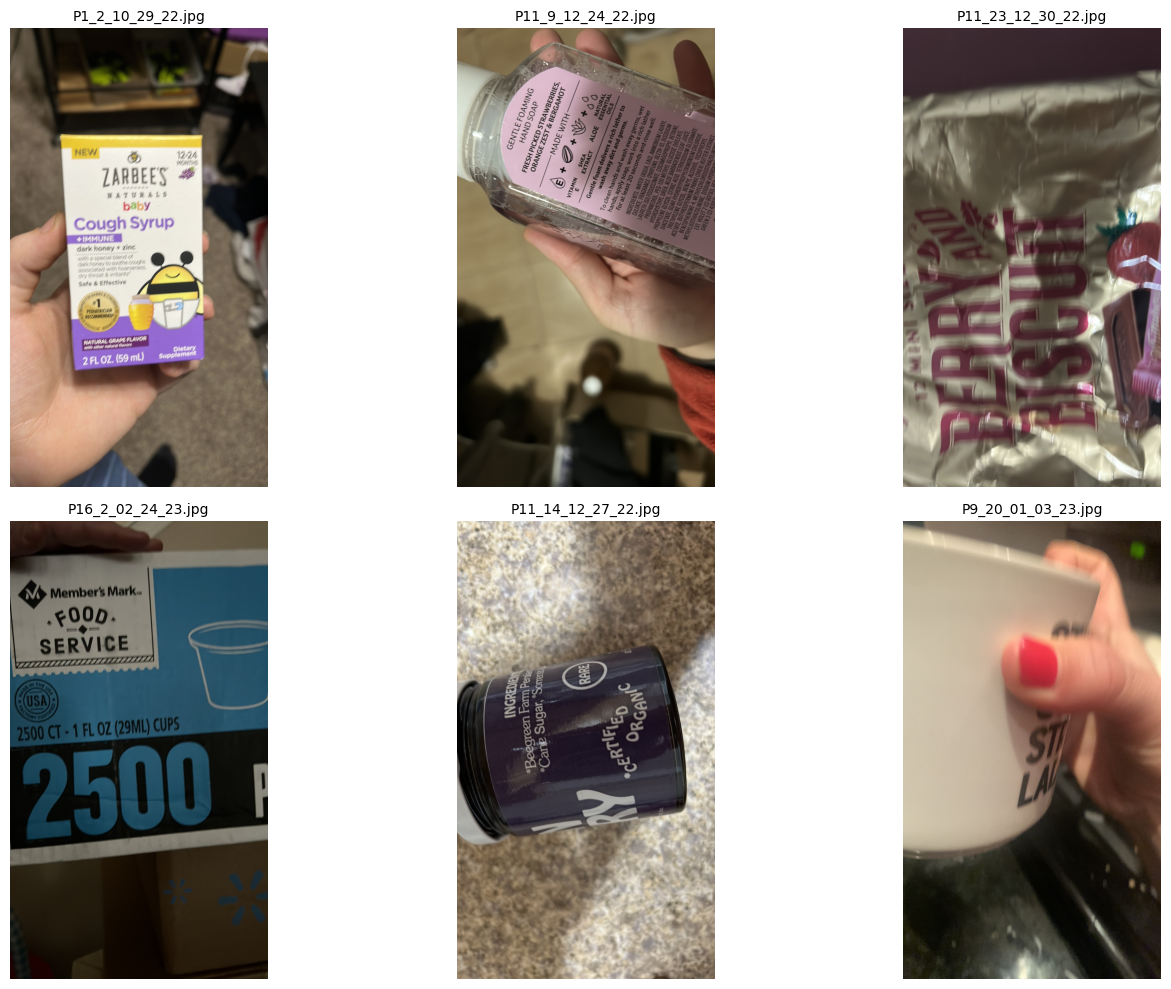

In [ ]:
#print(multimodal_collection.peek() )
#print(multimodal_collection.count())
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import os

query = output['image_description'] + " " + " ".join(output['tags'])

retrieved = mm_collection.query(query_texts=[query], include=['data'], n_results=6)
print(retrieved['ids'])

# Step 1: Extract filenames from retrieved IDs
retrieved_filenames = [id_str.split('/')[-1] for id_str in retrieved['ids'][0]]

# Step 2: Match to full paths
matched_paths = [p for name in retrieved_filenames for p in image_paths if name in p]

# Step 3: Plot with EXIF-corrected orientation
n_images = len(matched_paths)
n_cols = 3
n_rows = (n_images + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, path in enumerate(matched_paths):
    img = Image.open(path)
    img = ImageOps.exif_transpose(img)  # 👈 this line auto-rotates based on EXIF
    axes[i].imshow(img)
    axes[i].set_title(os.path.basename(path), fontsize=10)
    axes[i].axis('off')

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()




# Load Images for Embeddings and create image paths -- KEEP!

In [ ]:
# 0) (Optional) install helpers
!pip install --quiet requests tqdm

# 1) Authenticate & build Drive service
from google.colab import auth
auth.authenticate_user()  # click link + paste token

from googleapiclient.discovery import build
drive = build('drive', 'v3', cache_discovery=False)

# 2) List every file in the public folder
folder_id = '1JlPUuzTpKrteGsXr8NLmMz1fEXqQlhHo'
files = []
page_token = None
while True:
    resp = drive.files().list(
        q=f"'{folder_id}' in parents and trashed=false",
        spaces='drive',
        fields='nextPageToken, files(id, name)',
        pageToken=page_token
    ).execute()
    files.extend(resp.get('files', []))
    page_token = resp.get('nextPageToken')
    if not page_token:
        break

print(f"Found {len(files)} files.")

# 3) Download in parallel via HTTP
import os, requests
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

output_dir = 'images'
os.makedirs(output_dir, exist_ok=True)

def download_file(f):
    fid, name = f['id'], f['name']
    url = f"https://drive.google.com/uc?export=download&id={fid}"
    out_path = os.path.join(output_dir, name)
    try:
        with requests.get(url, stream=True, timeout=60) as r:
            r.raise_for_status()
            with open(out_path, 'wb') as fh:
                for chunk in r.iter_content(8192):
                    if chunk:
                        fh.write(chunk)
        return True, name
    except Exception as e:
        return False, f"{name} → {e}"

# tweak max_workers up/down depending on your network
with ThreadPoolExecutor(max_workers=8) as ex:
    results = list(tqdm(ex.map(download_file, files), total=len(files)))

# report
success = sum(1 for ok,_ in results if ok)
failures = [msg for ok,msg in results if not ok]
print(f"\n✅ {success} succeeded, {len(failures)} failed.")
if failures:
    print("\nFailures:")
    print("\n".join(failures))

print("CWD:", os.getcwd())            # should be /content
print("Images:", os.listdir("images"))
image_folder = "images"               # relative to /content
image_paths = sorted([
    os.path.join(image_folder, fn)
    for fn in os.listdir(image_folder)
    if os.path.isfile(os.path.join(image_folder, fn))
])
print(image_paths)

Found 317 files.


100%|██████████| 317/317 [01:34<00:00,  3.34it/s]


✅ 317 succeeded, 0 failed.
CWD: /content
Images: ['P7_7_11_17_22.jpg', 'P1_15_11_12_22.jpg', 'P2_20_10_31_22.jpg', 'P8_18_12_22_22.jpg', 'P5_12_11_22_22.jpg', 'P8_10_12_20_22.jpg', 'P2_7_10_25_22.jpg', 'P1_10_11_07_22.jpg', 'P7_17_11_27_22.jpg', 'P15_5_02_15_23.jpg', 'P10_32_12_23_22.jpg', 'P12_10_01_20_23.jpg', 'P2_29_11_01_22.jpg', 'P7_18_11_27_22.jpg', 'P12_15_01_22_23.jpg', 'P4_11_12_05_22.jpg', 'P4_12_12_05_22.jpg', 'P9_2_12_14_22.jpg', 'P15_15_02_21_23.jpg', 'P3_20_11_18_22.jpg', 'P3_19_11_18_22.jpg', 'P12_6_01_16_23.jpg', 'P9_15_12_26_22.jpg', 'P4_4_11_13_22.jpg', 'P8_15_12_20_22.jpg', 'P16_14_03_07_23.jpg', 'P11_18_12_27_22.jpg', 'P1_17_11_14_22.jpg', 'P14_14_01_29_23.jpg', 'P5_7_11_18_22.jpg', 'P15_17_02_23_23.jpg', 'P8_13_12_20_22.jpg', 'P15_4_02_14_23.jpg', 'P9_14_12_26_22.jpg', 'P14_20_02_04_23.jpg', 'P14_19_02_04_23.jpg', 'P10_5_12_16_22.jpg', 'P8_6_12_16_22.jpg', 'P9_18_01_03_23.jpg', 'P10_4_12_16_22.jpg', 'P10_33_12_23_22.jpg', 'P11_6_12_20_22.jpg', 'P3_2_11_04_22.jpg',

# Images URLs

In [ ]:
from google.colab import auth
from googleapiclient.discovery import build
import numpy as np

# 1) Authenticate & build Drive service
auth.authenticate_user()
drive = build('drive', 'v3', cache_discovery=False)

# 2) List every file in the public folder *including* webContentLink
folder_id = '1JlPUuzTpKrteGsXr8NLmMz1fEXqQlhHo'
files = []
page_token = None
while True:
    resp = drive.files().list(
        q=f"'{folder_id}' in parents and trashed=false",
        spaces='drive',
        # request the direct-download link and the web-view link
        fields='nextPageToken, files(id, name, mimeType, webContentLink, webViewLink)',
        pageToken=page_token
    ).execute()
    files.extend(resp.get('files', []))
    page_token = resp.get('nextPageToken')
    if not page_token:
        break

# 3) Filter to only images (optional) and pull out the links
image_files = [f for f in files if f['mimeType'].startswith('image/')]
download_urls = [f['webContentLink'] for f in image_files]
view_urls     = [f['webViewLink']    for f in image_files]

# 4) (Optional) into NumPy arrays
download_urls_array = download_urls
view_urls_array     = view_urls

print("Download URLs:", download_urls_array)
print("View URLs:    ", view_urls_array)
